In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
df_paths = []

data = glob.glob("E:/coro. 1/Data/calcified/*.jpg")
for i in data:
    df_paths.append(i)

data = glob.glob("E:/coro. 1/Data/normal/*.jpg")
for i in data:
    df_paths.append(i)

data = glob.glob("E:/coro. 1/Data/mixed/*.jpg")
for i in data:
    df_paths.append(i)

data = glob.glob("E:/coro. 1/Data/soft/*.jpg")
for i in data:
    df_paths.append(i)

In [3]:
len(df_paths)

722

In [4]:
lab_paths = []

data = glob.glob("E:/coro. 1/Labels/calcified/*.jpg")
for i in data:
    lab_paths.append(i)

data = glob.glob("E:/coro. 1/Labels/normal/*.jpg")
for i in data:
    lab_paths.append(i)

data = glob.glob("E:/coro. 1/Labels/mixed/*.jpg")
for i in data:
    lab_paths.append(i)

data = glob.glob("E:/coro. 1/Labels/soft/*.jpg")
for i in data:
    lab_paths.append(i)

In [5]:
lab_paths[472], df_paths[472]

('E:/coro. 1/Labels/mixed\\131.jpg', 'E:/coro. 1/Data/mixed\\131.jpg')

In [6]:
# Function to crop the coronary from the original image
def crop(path):
    image = cv2.imread(path)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_purple = np.array([125, 50, 50])
    upper_purple = np.array([155, 255, 255])

    mask = cv2.inRange(hsv_image, lower_purple, upper_purple)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)        
        x, y, w, h = cv2.boundingRect(largest_contour)        
        cropped_image = image[y:y+h, x:x+w]

    return mask, cropped_image

In [7]:
# Function to make the mask from the annotated images
def remo(data_path, label_path):
    original_image = cv2.imread(data_path)
    mask_image = cv2.imread(label_path)

    hsv_mask = cv2.cvtColor(mask_image, cv2.COLOR_BGR2HSV)

    lower_purple = np.array([120, 50, 50])
    upper_purple = np.array([160, 255, 255])

    purple_mask = cv2.inRange(hsv_mask, lower_purple, upper_purple)
    result = cv2.bitwise_and(original_image, original_image, mask=purple_mask)

    return result

In [149]:
df = []
labs = []

for i in range(len(df_paths)):
    # data_mask, data_result, data_purble = crop(data[i])
    image = cv2.imread(df_paths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    lab_mask = remo(df_paths[i], lab_paths[i])
    lab_mask[lab_mask >= 10] = 255
    lab_mask[lab_mask < 10] = 0
    df.append(image)
    labs.append(lab_mask)
    
len(df), len(labs)

(722, 722)

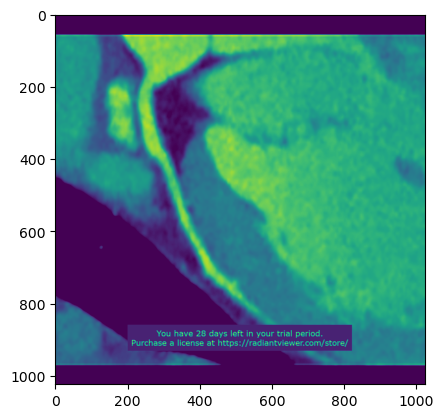

In [181]:
plt.imshow(df[100])

In [182]:
# Function to ensure that all images has the same shape
def func(df):
    resized_list = []
    for i in df:
        for arr in df:
            if arr.shape[0] != 1924:
                resized_arr = cv2.resize(arr, (224, 224))  # Resize to 224x224 (height, width)
                
                if resized_arr.ndim == 2:
                    resized_arr = np.stack((resized_arr,) * 3, axis=-1)
                elif resized_arr.shape[2] != 3:
                    resized_arr = resized_arr[:, :, :3]

                resized_list.append(resized_arr)
            else:
                resized_list.append(arr)
        return resized_list
    
resized_lst = func(df)
resized_labs = func(labs)
print(f"Number of arrays: {len(resized_labs)}, {len(resized_lst)}")

Number of arrays: 722, 722


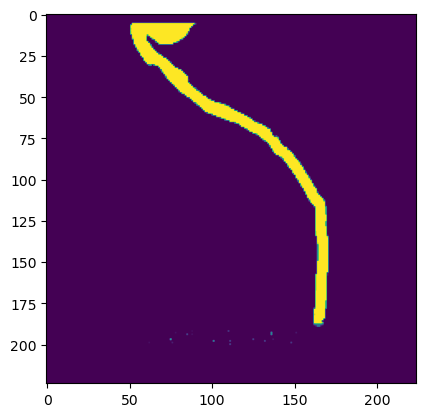

In [13]:
plt.imshow(resized_arrays[50])

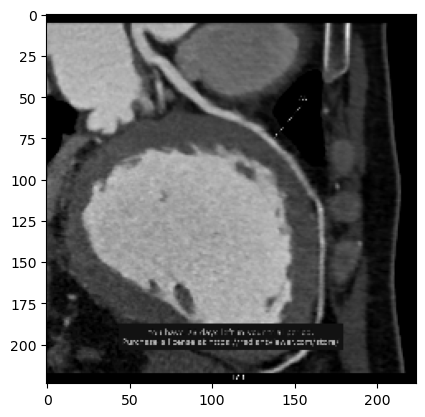

In [11]:
plt.imshow(resized_lst[50])

In [101]:
# loop on all masks to resize all of it to be (224, 224, 3) and stack it

resized_arrays = []
for i, arr in enumerate(resized_labs):
    try:
        if arr.ndim == 3 and arr.shape[-1] == 3:
            arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
        
        resized = cv2.resize(arr, (224, 224))
        resized = np.expand_dims(resized, axis=-1)
        resized_arrays.append(resized)
        
    except Exception as e:
        print(f"Error processing array at index {i}: {e}")

# Now stack the arrays
Labels = np.stack(resized_labs)

print(f"Original list length: {len(resized_labs)}, Resized list length: {len(resized_arrays)}, new stack shape: {Labels}")

Original list length: 722, Resized list length: 722


In [103]:
# loop on all images to resize all of it to be (224, 224, 3) and stack it

resized_list = []
for i, arr in enumerate(resized_lst):
    if arr.shape != (5784, 1024, 3):
        resized_arr = cv2.resize(arr, (224, 224))
        
        if resized_arr.ndim == 2:
            resized_arr = np.stack((resized_arr,) * 3, axis=-1)
        
        elif resized_arr.shape[2] != 3:
            resized_arr = resized_arr[:, :, :3]
        
        resized_list.append(resized_arr)
    else:
        resized_list.append(arr)


resized_Data = np.stack(resized_list)
print(resized_Data.shape) 

(722, 224, 224, 3)


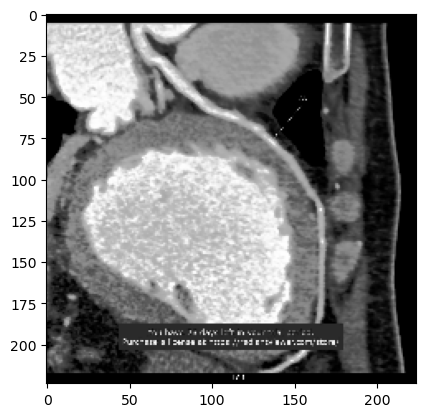

In [183]:
plt.imshow(resized_Data[50])

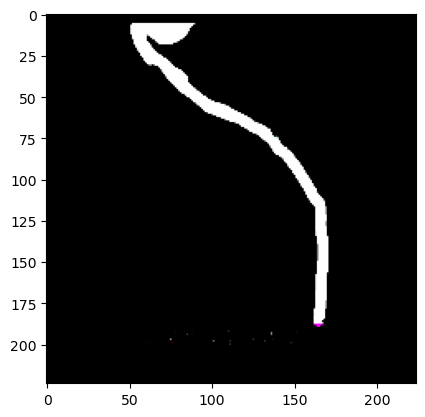

In [184]:
plt.imshow(Labels[50])

In [104]:
def adjust_to_single_channel(labels):
    # Select one of the channels, for example, the first one (index 0)
    labels_single_channel = labels[..., 0]  # Select the first channel (convert from RGB to grayscale)
    labels_single_channel = np.expand_dims(labels_single_channel, axis=-1)
    
    return labels_single_channel

labels_train = adjust_to_single_channel(Labels)
print(f"New label shape: {labels_train.shape}")

New label shape: (722, 224, 224, 1)


In [105]:
data_test = resized_Data[:50]
data_train = resized_Data[50:]

labs_test = labels_train[:50]
labs_train = labels_train[50:]

print(f'Training Data Shape: {data_train.shape}')
print(f'Test Data Shape: {data_test.shape}')
print(f'Training Labels Shape: {labs_train.shape}')
print(f'Test Labels Shape: {labs_test.shape}')

Training Data Shape: (672, 224, 224, 3)
Test Data Shape: (50, 224, 224, 3)
Training Labels Shape: (672, 224, 224, 1)
Test Labels Shape: (50, 224, 224, 1)


In [106]:
train_images = data_train / 255.0
train_masks = labs_train / 255.0
val_images = data_test / 255.0
val_masks = labs_test / 255.0

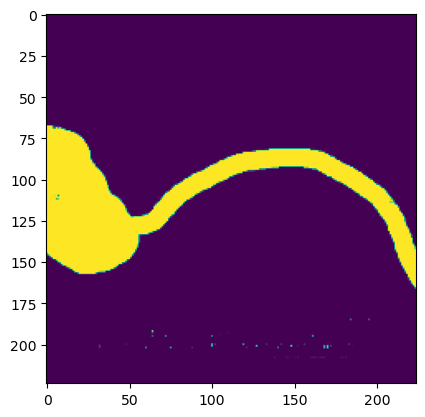

In [185]:
plt.imshow(train_masks[500])

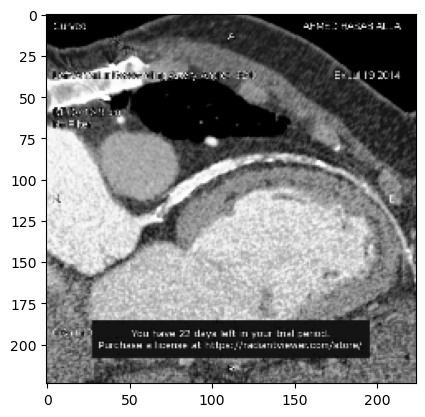

In [186]:
plt.imshow(train_images[500])

In [113]:
def build_model(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2], axis=-1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1], axis=-1)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model9 = build_model(input_shape=(224, 224, 3))
model9.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 224, 224, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 conv2d_44 (Conv2D)          (None, 224, 224, 64)         36928     ['conv2d_43[0][0]']           
                                                                                                  
 max_pooling2d_13 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_44[0][0]']           
 ng2D)                                                                                      

In [114]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model9.fit(train_images, train_masks, validation_data=(val_images, val_masks),
                    epochs=50, batch_size=8, callbacks=[early_stopping])

Epoch 1/50
84/84 [==============================] - 367s 4s/step - loss: 0.2631 - accuracy: 0.9206 - val_loss: 0.2181 - val_accuracy: 0.9131
Epoch 2/50
84/84 [==============================] - 356s 4s/step - loss: 0.1821 - accuracy: 0.9293 - val_loss: 0.2298 - val_accuracy: 0.9157
Epoch 3/50
84/84 [==============================] - 354s 4s/step - loss: 0.1676 - accuracy: 0.9384 - val_loss: 0.1760 - val_accuracy: 0.9272
Epoch 4/50
84/84 [==============================] - 355s 4s/step - loss: 0.1529 - accuracy: 0.9421 - val_loss: 0.1802 - val_accuracy: 0.9302
Epoch 5/50
84/84 [==============================] - 355s 4s/step - loss: 0.1486 - accuracy: 0.9438 - val_loss: 0.1541 - val_accuracy: 0.9390
Epoch 6/50
84/84 [==============================] - 354s 4s/step - loss: 0.1417 - accuracy: 0.9454 - val_loss: 0.1519 - val_accuracy: 0.9396
Epoch 7/50
84/84 [==============================] - 355s 4s/step - loss: 0.1312 - accuracy: 0.9485 - val_loss: 0.1713 - val_accuracy: 0.9347
Epoch 8/50
84

In [187]:
model9.save('E:/coro. 1/Segmentation_model9.h5')

In [122]:
input_shape = (224, 224, 1)

def build_autoencoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = models.Model(inputs, outputs)
    return autoencoder

model1 = build_autoencoder(input_shape)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_54 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 56, 56, 128)       7385

In [123]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

history = model1.fit(predicted_tensor, train_masks, 
                     epochs=100, 
                     batch_size=16, 
                     validation_data=(val_tensor, val_masks),
                     callbacks=[early_stopping])

Epoch 1/100
42/42 [==============================] - 44s 1s/step - loss: 0.2357 - accuracy: 0.9315 - val_loss: 0.1850 - val_accuracy: 0.9434
Epoch 2/100
42/42 [==============================] - 43s 1s/step - loss: 0.1075 - accuracy: 0.9600 - val_loss: 0.1627 - val_accuracy: 0.9469
Epoch 3/100
42/42 [==============================] - 50s 1s/step - loss: 0.0992 - accuracy: 0.9621 - val_loss: 0.1730 - val_accuracy: 0.9482
Epoch 4/100
42/42 [==============================] - 57s 1s/step - loss: 0.0951 - accuracy: 0.9633 - val_loss: 0.1774 - val_accuracy: 0.9492
Epoch 5/100
42/42 [==============================] - 58s 1s/step - loss: 0.0916 - accuracy: 0.9640 - val_loss: 0.1492 - val_accuracy: 0.9497
Epoch 6/100
42/42 [==============================] - 58s 1s/step - loss: 0.0894 - accuracy: 0.9647 - val_loss: 0.1699 - val_accuracy: 0.9501
Epoch 7/100
42/42 [==============================] - 47s 1s/step - loss: 0.0878 - accuracy: 0.9647 - val_loss: 0.1456 - val_accuracy: 0.9501
Epoch 8/100
4

In [126]:
model1.save('E:/coro. 1/AutoEncoderModel.h5')

In [65]:
train_masks = np.where(train_masks > 0.5, 1, 0)
val_masks = np.where(val_masks > 0.5, 1, 0)

2
1/1 [==============================] - 0s 73ms/step


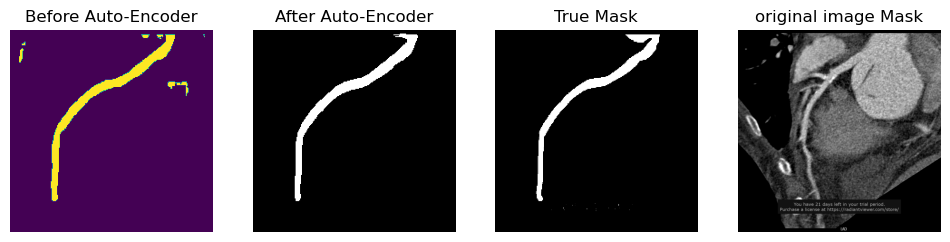

In [152]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random image from the validation set
random_index = random.randint(0, len(val_tensor) - 1)
sample_image = predicted_tensor[random_index]
sample_mask = train_masks[random_index]

print(random_index)

# Expand dimensions to match model input shape (batch of 1)
sample_image_input = np.expand_dims(sample_image, axis=0)

# Predict the mask
predicted0_mask = model1.predict(sample_image_input)[0]  # Remove batch dimension

# Threshold the predicted mask (convert to binary if using binary segmentation)
predicted_mask_thresholded = (predicted0_mask > 0.5).astype(np.uint8)

# Plot the original image, true mask, and predicted mask
plt.figure(figsize=(12, 4))

# Display original image
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.title('Before Auto-Encoder')
plt.axis('off')

# Display true mask
plt.subplot(1, 4, 3)
plt.imshow(sample_mask[:, :, 0], cmap='gray')  # Assuming the true mask is 1-channel
plt.title('True Mask')
plt.axis('off')

# Display predicted mask
plt.subplot(1, 4, 2)
plt.imshow(predicted_mask_thresholded[:, :, 0], cmap='gray')  # Assuming the prediction is 1-channel
plt.title('After Auto-Encoder')
plt.axis('off')

# Display predicted mask
plt.subplot(1, 4, 4)
plt.imshow(df[random_index], cmap='gray')  # Assuming the prediction is 1-channel
plt.title('original image Mask')
plt.axis('off')


# Show the plots
plt.show()


In [117]:
def fnc(train_images0, index):
    sample_image = train_images0[index]
    sample_image_input = np.expand_dims(sample_image, axis=0)
    predicted_mask = model9.predict(sample_image_input)[0]  # Remove batch dimension
    predicted_mask_thresholded = (predicted_mask > 0.5).astype(np.uint8)

    return predicted_mask_thresholded

In [118]:
predicted = []

for i in range(len(train_images)):
    predictedMask = fnc(train_images,i)
    predicted.append(predictedMask)

1/1 [==============================] - 0s 130ms/step


In [119]:
val_predicted = []

for i in range(len(val_images)):
    predictedMask = fnc(val_images,i)
    val_predicted.append(predictedMask)

1/1 [==============================] - 0s 131ms/step


In [120]:
predicted_expanded = [img if img.shape == (224, 224, 1) else np.expand_dims(img, axis=-1) for img in predicted]
predicted_tensor = tf.convert_to_tensor(predicted_expanded)

print(predicted_tensor.shape)

(672, 224, 224, 1)


In [121]:
predicted_expanded = [img if img.shape == (224, 224, 1) else np.expand_dims(img, axis=-1) for img in val_predicted]
val_tensor = tf.convert_to_tensor(predicted_expanded)

print(val_tensor.shape)

(50, 224, 224, 1)


In [171]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ensure both the true masks and predicted masks are binary
val_true_masks = (val_masks > 0).astype(int)  # Convert true masks to binary if not already
val_pred_masks = model9.predict(val_images)
val_pred_masks = (val_pred_masks > 0.5).astype(int)  # Threshold predictions to binary

# Flatten arrays to calculate pixel-level metrics
y_true_flat = val_true_masks.flatten()
y_pred_flat = val_pred_masks.flatten()

# Calculate metrics
precision = precision_score(y_true_flat, y_pred_flat, zero_division=1)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=1)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=1)

# Display results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


2/2 [==============================] - 6s 2s/step
Precision: 0.743032627694698
Recall: 0.5618128086051506
F1 Score: 0.6398386135819633


In [178]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ensure both the true masks and predicted masks are binary
val_true_masks = (val_masks > 0).astype(int)  # Convert true masks to binary if not already
val_pred_masks = model1.predict(val_tensor)
val_pred_masks = (val_pred_masks > 0.5).astype(int)  # Threshold predictions to binary

# Flatten arrays to calculate pixel-level metrics
y_true_flat = val_true_masks.flatten()
y_pred_flat = val_pred_masks.flatten()

# Calculate metrics
precision = precision_score(y_true_flat, y_pred_flat, zero_division=1)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=1)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=1)

# Display results
print(f"Model evaluation metrics:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


2/2 [==============================] - 0s 181ms/step
Model evaluation metrics:
Precision: 0.8173678270574958
Recall: 0.601548303015841
F1 Score: 0.6930448091823004
